# Creating the initial conditions

In [1]:
from roms_tools import Grid, InitialConditions

We start by creating a grid that contains Iceland and has a horizontal resolution of 2 km and 100 vertical layers.

In [2]:
grid = Grid(
    nx=500,
    ny=500,
    size_x=1000,
    size_y=1000,
    center_lon=-20,
    center_lat=65,
    rot=0,
    N=100,
    topography_source={
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    },
)

Next, we specify the time that we want to make the initial conditions for.

In [3]:
from datetime import datetime

In [4]:
ini_time = datetime(2012, 1, 2)

## Physical initial conditions from GLORYS
In this section, we use GLORYS data to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities. (We will learn how to add biogeochemical initial conditions further down in the notebook.) Our downloaded GLORYS data sits at the following location.

In [5]:
path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc"

<div class="alert alert-info">

Note

It would also be okay to provide a filename that contains data for more than just the day of interest. `ROMS-Tools` will pick out the correct day (and complain if the day of interest is not in the provided filename.) Or we can even use wildcards, such as `path="/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/*.nc"`. Note, however, that `ROMS-Tools` will operate more efficiently when the filename is as specific as possible.
    
</div>

You can also download your own GLORYS data, which must span the desired ROMS domain and `ini_time`. For more details, please refer to [this page](https://roms-tools.readthedocs.io/en/latest/datasets.html).

We can now create the `InitialConditions` object.

In [6]:
%%time

initial_conditions = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    model_reference_date=datetime(
        2000, 1, 1
    ),  # model reference date. Default is January 1, 2000,
    use_dask=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


CPU times: user 1min 10s, sys: 311 ms, total: 1min 11s
Wall time: 3.02 s


<div class="alert alert-info">

Note

In the cell above, we created our initial conditions with `use_dask = True`. This enables `Dask`, a Python library designated to facilitate scalable, out-of-memory data processing by distributing computations across multiple threads or processes. [Here](https://roms-tools.readthedocs.io/en/latest/using_dask.html) you can learn more about using `Dask` with `ROMS-Tools`.

</div>

The initial conditions variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [7]:
initial_conditions.ds

<xarray.Dataset> Size: 508MB
Dimensions:     (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                 xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables:
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 1MB -0.7429 ... -0.8718
    ubar        (eta_rho, xi_u, ocean_time) float32 1MB dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    vbar        (eta_v, xi_rho, ocean_time) float32 1MB dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    w           (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 0.0 ... 0.0
    Cs_r        (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w        (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   0.1.dev177
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

Let's make some plots! As an example, let's have a look at the temperature field `temp`. It is three-dimensional with horizontal dimensions `eta_rho` and `xi_rho`, and vertical dimension `s_rho`.

We first want to plot different layers of the temperature field, i.e., slice along the vertical dimension `s`.

[########################################] | 100% Completed | 6.97 sms


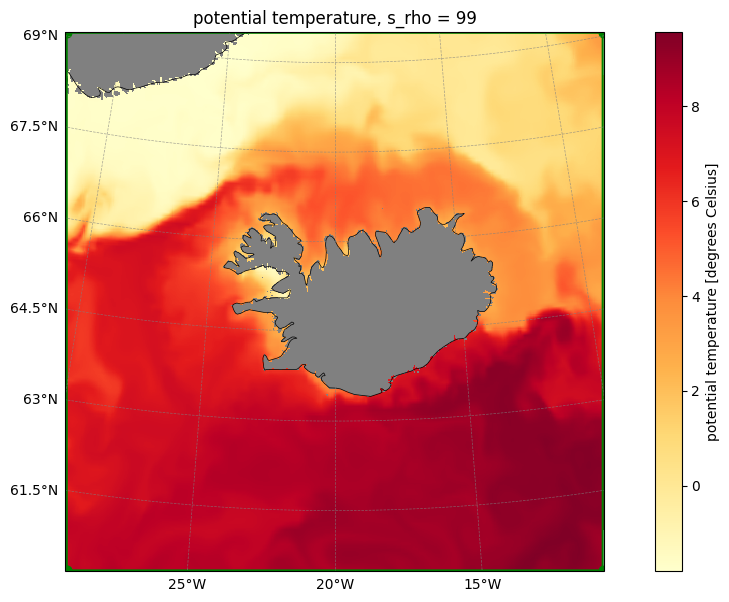

In [8]:
initial_conditions.plot("temp", s=-1)  # plot uppermost layer

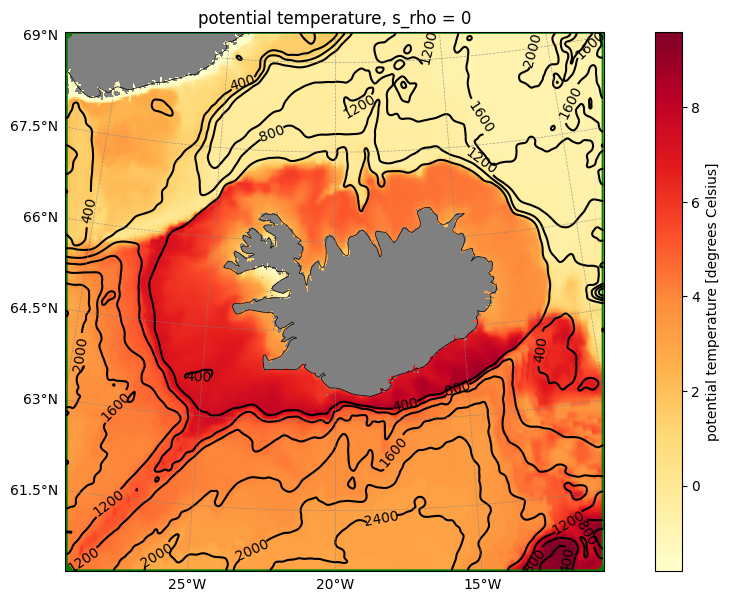

In [9]:
initial_conditions.plot("temp", s=0, depth_contours=True)  # plot bottom layer

Next, we slice our domain along one of the horizontal dimensions and look at temperature along these sections.

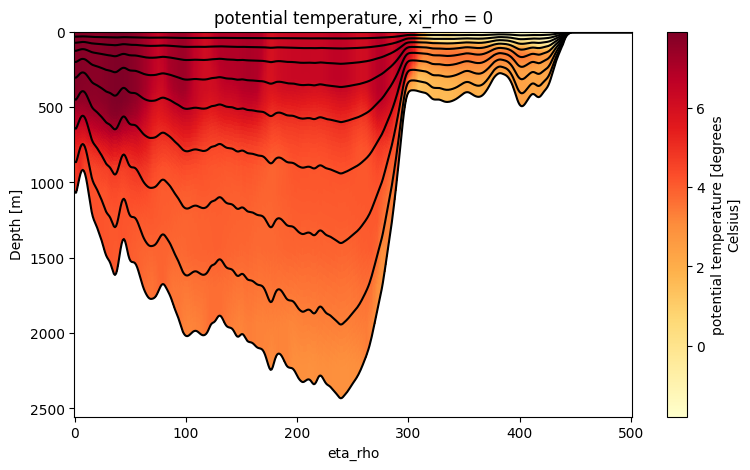

In [10]:
initial_conditions.plot("temp", xi=0, layer_contours=True)

Note that even though we have a total of 100 layers, `layer_contours = True` will create a plot with a maximum of 10 contours to ensure plot clarity.

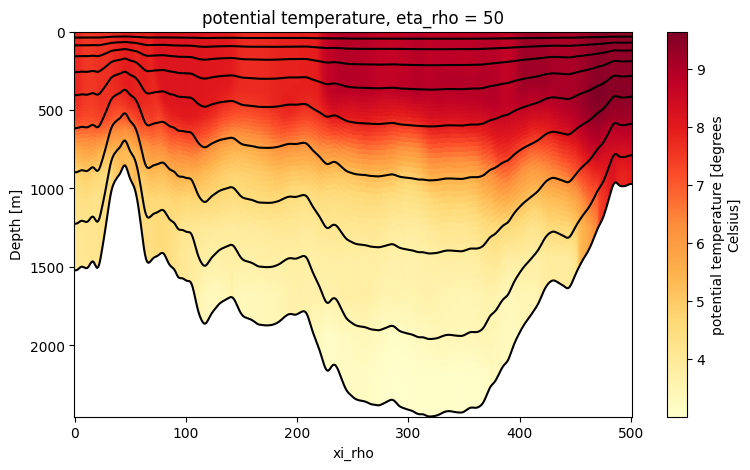

In [11]:
initial_conditions.plot("temp", eta=50, layer_contours=True)

We can also plot a depth profile at at certain spatial location.

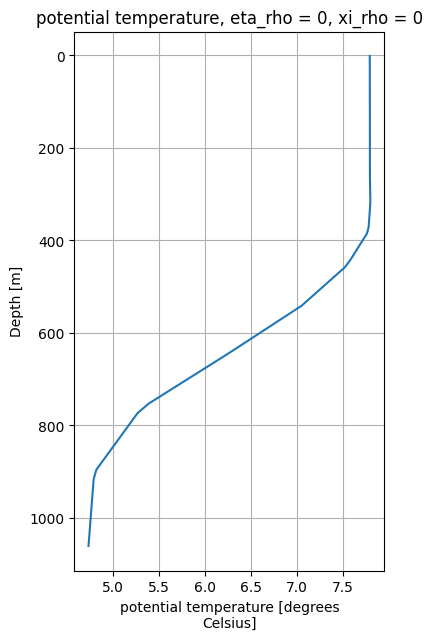

In [12]:
initial_conditions.plot("temp", eta=0, xi=0)

Finally, we can look at a transect in a certain layer and at a fixed `eta_rho` (similarly `xi_rho`).

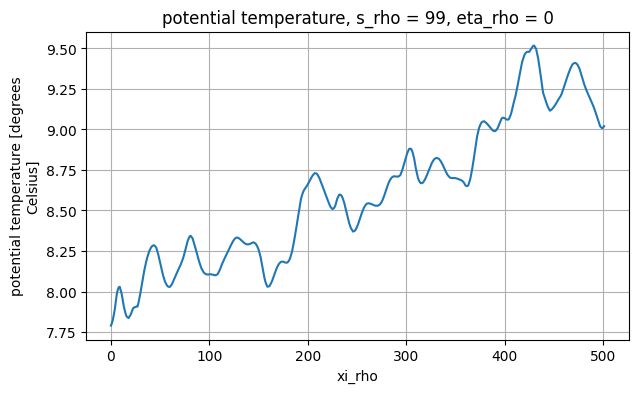

In [13]:
initial_conditions.plot("temp", eta=0, s=-1)

Plotting velocity fields works similarly.

[########################################] | 100% Completed | 7.03 sms


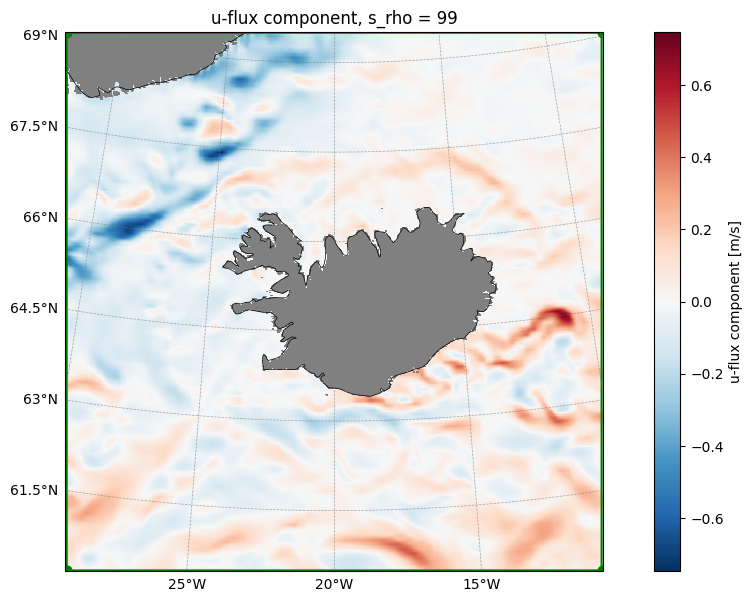

In [14]:
initial_conditions.plot("u", s=-1)  # plot uppermost layer

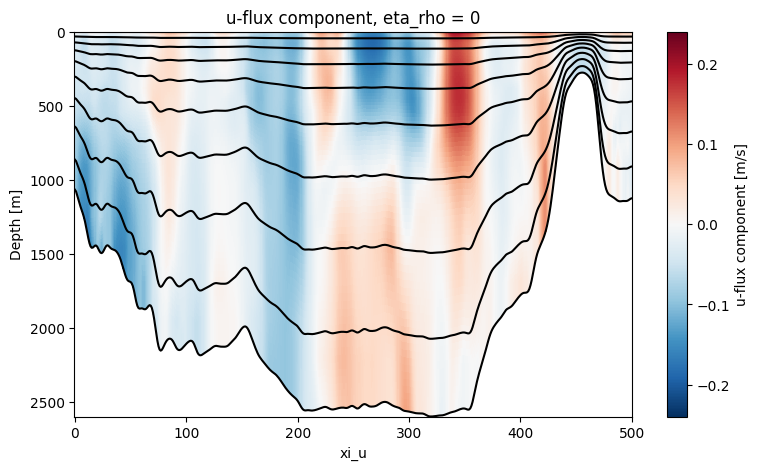

In [15]:
initial_conditions.plot("u", eta=0, layer_contours=True)

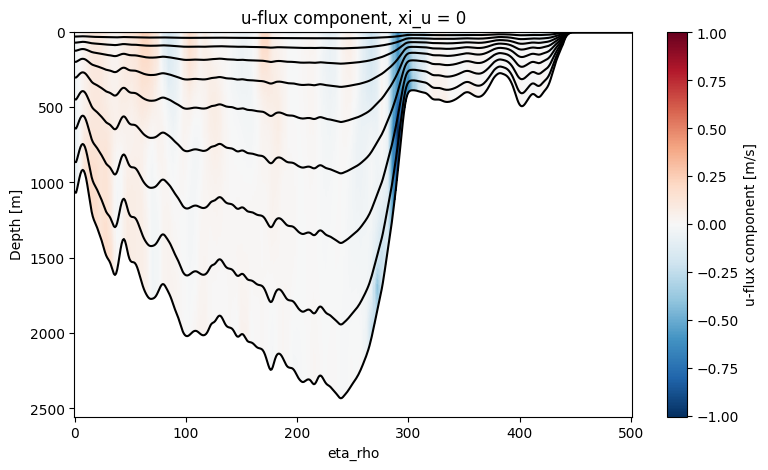

In [16]:
initial_conditions.plot("u", xi=0, layer_contours=True)

[########################################] | 100% Completed | 6.50 sms


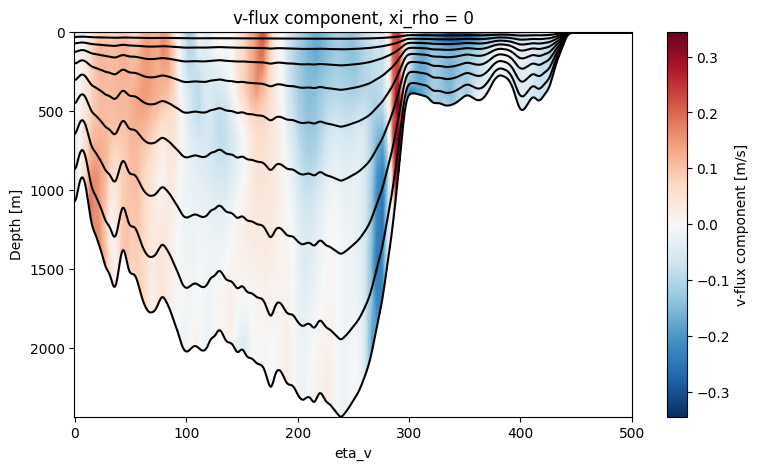

In [17]:
initial_conditions.plot("v", xi=0, layer_contours=True)

## Adding Biogeochemical (BGC) Initial Conditions  

To prepare a ROMS simulation with MARBL biogeochemistry (BGC), we need to generate both physical and biogeochemical initial conditions. Since ROMS requires a single initial conditions file, we create both sets of conditions together.  

We use the following datasets:  

- **Physical Initial Conditions:**  
  Derived from GLORYS data, including temperature, salinity, sea surface height, and velocities.  

- **Biogeochemical (BGC) Initial Conditions:**  
  Constructed from a climatology with 1° horizontal resolution, using two different approaches:  
  1. **CESM BGC climatology**  
  2. **A unified BGC climatology** combining multiple observationally based sources:  
     - Nutrient concentrations (nitrate, phosphate, silicate) and dissolved oxygen from the 2018 World Ocean Atlas  
     - Dissolved iron and nitrous oxide from in-situ measurements  
     - Dissolved inorganic carbon (DIC) and alkalinity from the global GLODAPv2 product  

Both BGC climatologies can be accessed at the following locations:  

In [18]:
cesm_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"
unified_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/UNIFIED/BGCdataset.nc"

The initial conditions are created as above, but now with additional information about the `bgc_source`.

In [19]:
%%time

initial_conditions_with_cesm_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": cesm_bgc_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


CPU times: user 2min 4s, sys: 27.6 s, total: 2min 31s
Wall time: 10.9 s


In [20]:
initial_conditions_with_cesm_bgc.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB -0.7429 ... -0.8718
    ubar         (eta_rho, xi_u, ocean_time) float32 1MB dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   0.1.dev177
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           CESM_REGRIDDED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

In [21]:
%%time

initial_conditions_with_unified_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "UNIFIED",
        "path": unified_bgc_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=True,
)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


CPU times: user 2min 38s, sys: 55.4 s, total: 3min 33s
Wall time: 11 s


In [22]:
initial_conditions_with_unified_bgc.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB -0.7429 ... -0.8718
    ubar         (eta_rho, xi_u, ocean_time) float32 1MB dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    ...           ...
    diazC        (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    diazP        (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   0.1.dev177
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           UNIFIED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

[########################################] | 100% Completed | 6.03 sms


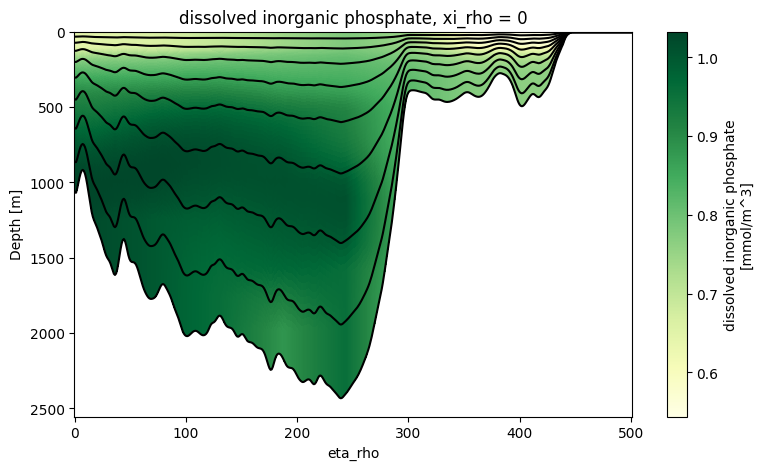

In [23]:
initial_conditions_with_cesm_bgc.plot("PO4", xi=0, layer_contours=True)

[########################################] | 100% Completed | 7.76 sms


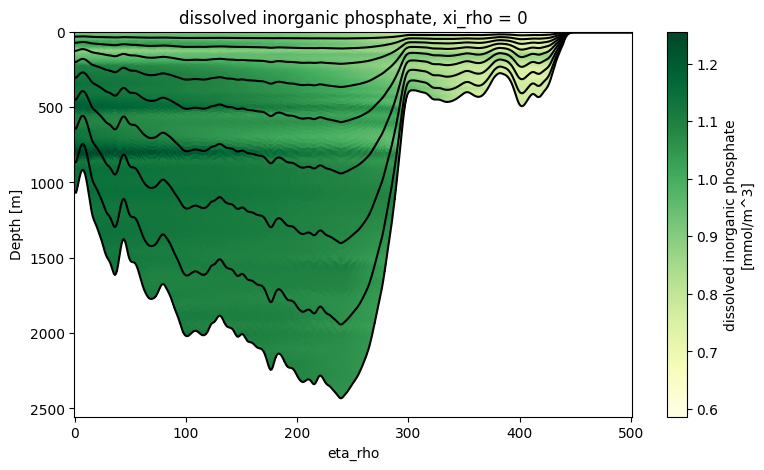

In [24]:
initial_conditions_with_unified_bgc.plot("PO4", xi=0, layer_contours=True)

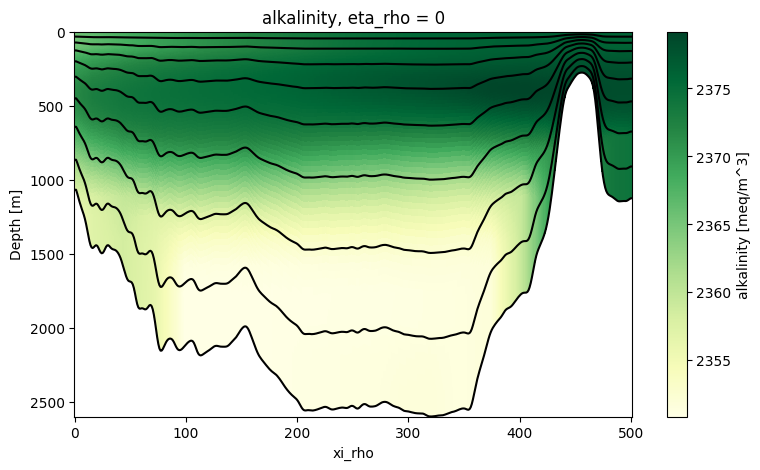

In [25]:
initial_conditions_with_cesm_bgc.plot("ALK", eta=0, layer_contours=True)

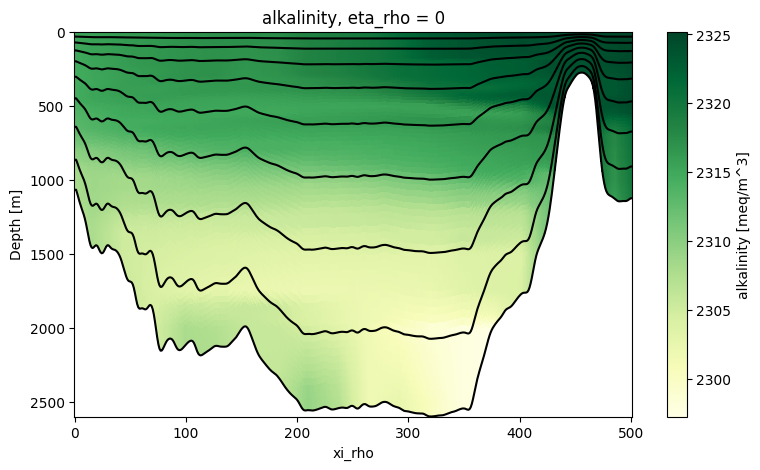

In [26]:
initial_conditions_with_unified_bgc.plot("ALK", eta=0, layer_contours=True)

## Adjusting the depth for sea surface height

`ROMS` uses a [terrain-following vertical coordinate system](https://roms-tools.readthedocs.io/en/latest/methods.html#vertical-coordinate-system). 
To regrid data from the depth coordinate of datasets like GLORYS/CESM onto the terrain-following ROMS coordinate system, `ROMS-Tools` internally computes the depth coordinates for the ROMS vertical coordinate system. The handling of sea surface height (SSH) depends on the value of the `adjust_depth_for_sea_surface_height` parameter:

* If `adjust_depth_for_sea_surface_height = False` (default), a constant sea surface height is assumed: $\zeta(x,y,t) = 0$.
* If `adjust_depth_for_sea_surface_height = True`, the depth calculations account for spatial and temporal variations in SSH.

Setting `adjust_depth_for_sea_surface_height = True` increases the complexity in the depth coordinate generation, as depths become time-dependent. While this approach may seem more accurate, its effectiveness depends on how source datasets (e.g., GLORYS) define their depth coordinates. It is often unclear whether these datasets measure depth relative to the surface (consistent with `adjust_depth_for_sea_surface_height = False`) or elevation above the bottom (consistent with `adjust_depth_for_sea_surface_height = True`). Given this uncertainty and the unclear benefit of adjusting for sea surface height variations, the default setting is `adjust_depth_for_sea_surface_height = False` for simplicity, and this approach has been used until now in this notebook.

Now, let's proceed by setting `adjust_depth_for_sea_surface_height = True`.

In [27]:
%%time

initial_conditions_with_cesm_bgc_adjusted_for_ssh = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": cesm_bgc_path,
        "climatology": True,
    },
    adjust_depth_for_sea_surface_height=True,  # default is False
    use_dask=True,
)

INFO - Sea surface height will be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


CPU times: user 2min 18s, sys: 27.4 s, total: 2min 46s
Wall time: 11.1 s


When making a plot as described above, it is hard to see a difference by eye. This outcome is expected due to the subtle nature of the sea surface height adjustments.

[########################################] | 100% Completed | 5.79 sms


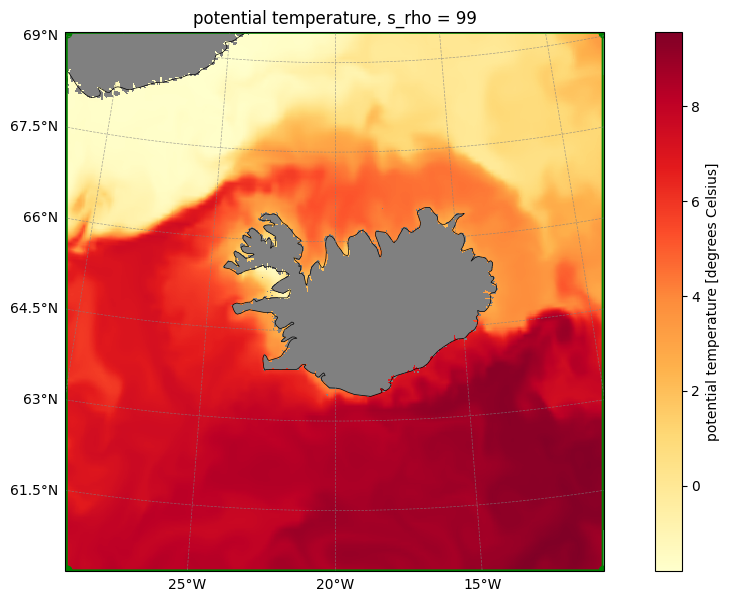

In [28]:
initial_conditions_with_cesm_bgc_adjusted_for_ssh.plot("temp", s=-1)  # uppermost layer

Let's plot the differences in sea surface temperature directly.

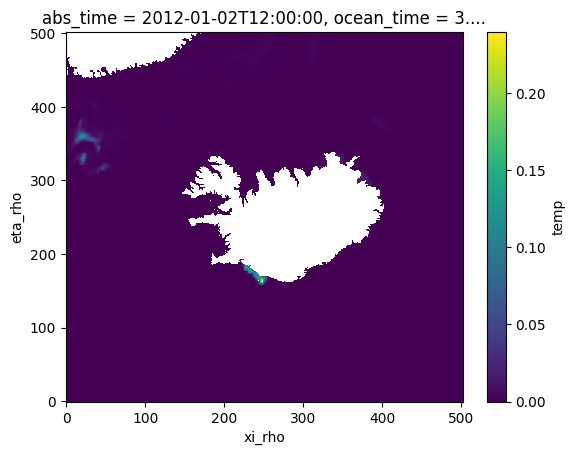

In [29]:
(
    initial_conditions_with_cesm_bgc_adjusted_for_ssh.ds["temp"]
    - initial_conditions_with_cesm_bgc.ds["temp"]
).where(grid.ds["mask_rho"]).isel(s_rho=-1).plot()

The plot above confirms that the differences are indeed subtle in this example.

## Saving as NetCDF or YAML file

We can now save the dataset as a NetCDF file.

In [30]:
filepath = "/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.nc"

In [31]:
%time initial_conditions_with_cesm_bgc.save(filepath)

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.nc


[########################################] | 100% Completed | 91.79 s
CPU times: user 31min 4s, sys: 5min 4s, total: 36min 9s
Wall time: 1min 37s


[PosixPath('/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.nc')]

We can also export the parameters of our `InitialConditions` object to a YAML file.

In [32]:
yaml_filepath = "/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.yaml"

In [33]:
initial_conditions_with_cesm_bgc.to_yaml(yaml_filepath)

In [34]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev177
---
Grid:
  nx: 500
  ny: 500
  size_x: 1000
  size_y: 1000
  center_lon: -20
  center_lat: 65
  rot: 0
  N: 100
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: SRTM15
    path: /global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc
  hmin: 5.0
InitialConditions:
  ini_time: '2012-01-02T00:00:00'
  source:
    name: GLORYS
    path: /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc
    climatology: false
  bgc_source:
    name: CESM_REGRIDDED
    path: /global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc
    climatology: true
  model_reference_date: '2000-01-01T00:00:00'
  adjust_depth_for_sea_surface_height: false
  horizontal_chunk_size: 50
  bypass_validation: false



## Creating initial conditions from an existing YAML file

In [35]:
%time the_same_initial_conditions_with_cesm_bgc = InitialConditions.from_yaml(yaml_filepath, use_dask=True)

INFO - Sea surface height will NOT be used to adjust depth coordinates.
INFO - Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']


CPU times: user 2min 1s, sys: 27.1 s, total: 2min 29s
Wall time: 14.4 s


In [36]:
the_same_initial_conditions_with_cesm_bgc.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB -0.7429 ... -0.8718
    ubar         (eta_rho, xi_u, ocean_time) float32 1MB dask.array<chunksize=(50, 50, 1), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 50, 50), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   0.1.dev177
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           CESM_REGRIDDED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0